In [19]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [ ]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 1797 files [00:03, 469.53 files/s]


In [21]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [22]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [23]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
6 folder and 0 images in output\test
0 folder and 15 images in output\test\0
0 folder and 15 images in output\test\MR
0 folder and 16 images in output\test\MRMS
0 folder and 16 images in output\test\MS
0 folder and 16 images in output\test\R
0 folder and 15 images in output\test\S
6 folder and 0 images in output\train
0 folder and 225 images in output\train\0
0 folder and 225 images in output\train\MR
0 folder and 224 images in output\train\MRMS
0 folder and 224 images in output\train\MS
0 folder and 224 images in output\train\R
0 folder and 225 images in output\train\S
6 folder and 0 images in output\val
0 folder and 60 images in output\val\0
0 folder and 60 images in output\val\MR
0 folder and 59 images in output\val\MRMS
0 folder and 59 images in output\val\MS
0 folder and 59 images in output\val\R
0 folder and 60 images in output\val\S


In [24]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (177, 977, 3)


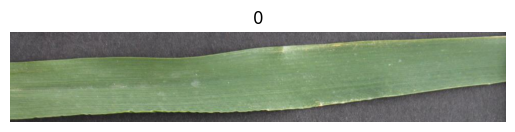

In [25]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='0')

Image Shape : (113, 1106, 3)


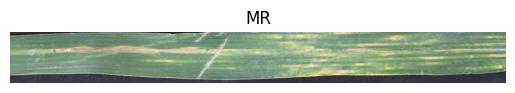

In [26]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='MR')

Image Shape : (128, 944, 3)


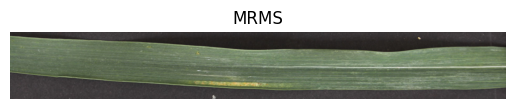

In [27]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='MRMS')

Image Shape : (117, 672, 3)


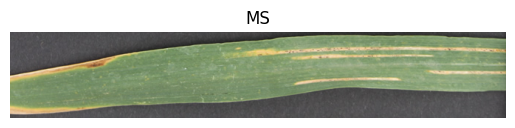

In [28]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='MS')

Image Shape : (126, 732, 3)


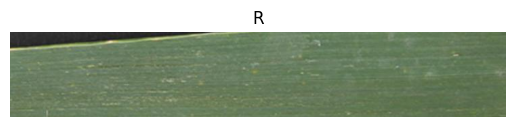

In [29]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='R')

Image Shape : (130, 1047, 3)


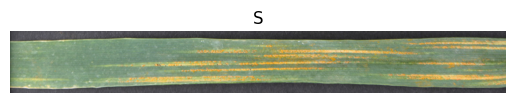

In [30]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='S')

In [31]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [32]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 1347 images belonging to 6 classes.
Found 357 images belonging to 6 classes.
Found 93 images belonging to 6 classes.


In [33]:
train_data.class_indices

{'0': 0, 'MR': 1, 'MRMS': 2, 'MS': 3, 'R': 4, 'S': 5}

In [34]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [35]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (1347,)
val_y.shape:  (357,)
test_y.shape:  (93,)


In [44]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Directories for data
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to create a model using VGG16 as base
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create and compile VGG16 model
vgg16_model = create_vgg16_model()
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train the VGG16 model
print("Training VGG16 Model...")
vgg16_model.fit(train_data, epochs=10, validation_data=val_data)

# Save the trained VGG16 model
vgg16_model.save("vgg16_model.h5")
print("VGG16 Model saved as 'vgg16_model.h5'.")


Found 1347 images belonging to 6 classes.
Found 357 images belonging to 6 classes.
Found 93 images belonging to 6 classes.
Training VGG16 Model...
Epoch 1/10
43/43 [==============================] - 199s 5s/step - loss: 1.7795 - accuracy: 0.2502 - val_loss: 1.5544 - val_accuracy: 0.4174
Epoch 2/10
43/43 [==============================] - 200s 5s/step - loss: 1.5433 - accuracy: 0.3482 - val_loss: 1.4421 - val_accuracy: 0.3277
Epoch 3/10
43/43 [==============================] - 201s 5s/step - loss: 1.4394 - accuracy: 0.3808 - val_loss: 1.3506 - val_accuracy: 0.4734
Epoch 4/10
43/43 [==============================] - 202s 5s/step - loss: 1.3739 - accuracy: 0.4269 - val_loss: 1.2777 - val_accuracy: 0.4930
Epoch 5/10
43/43 [==============================] - 202s 5s/step - loss: 1.3207 - accuracy: 0.4469 - val_loss: 1.2572 - val_accuracy: 0.5182
Epoch 6/10
43/43 [==============================] - 203s 5s/step - loss: 1.2817 - accuracy: 0.4677 - val_loss: 1.2315 - val_accuracy: 0.5630
Epoch 7

C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 245ms/step
Predicted Class: Resistant


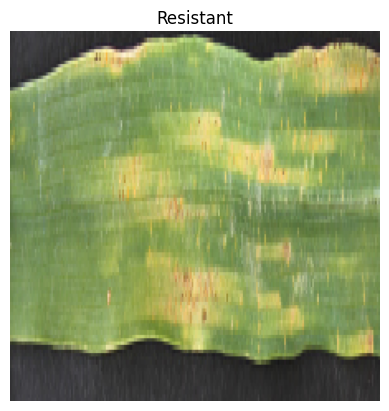

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained VGG16 model
model = load_model('vgg16_model.h5')

# Load the image you want to predict
image_path = r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset\MS\4_MS_09.jpg"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img_array = np.array(img)
img_array = img_array / 255.0  # Rescale the image
img_array = img_array.reshape(1, 224, 224, 3)  # Add batch dimension

# Predict the label
predicted_label = model.predict(img_array)

# Define class names based on the labels
class_names = ['No disease', 'Resistant', 'Moderately Resistant', 
               'Moderately Resistant-Moderately Susceptible', 
               'Moderately Susceptible', 'Susceptible']

# Get the predicted class index
predicted_class_index = np.argmax(predicted_label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(img)
plt.title(predicted_class)
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 261ms/step


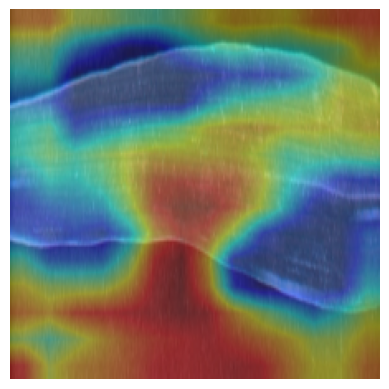

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# Load the trained model
model = tf.keras.models.load_model("vgg16_model.h5")

# Function to create Grad-CAM heatmap
def generate_grad_cam_heatmap(model, img_array, class_index, layer_name="block5_conv3"):
    # Get the last convolutional layer output
    last_conv_layer = model.get_layer(layer_name)
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        loss = predictions[:, class_index]
    
    # Get the gradient of the loss with respect to the convolutional layer output
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients over all the axes
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # Multiply the pooled gradients with the convolutional outputs
    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)
    
    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap = heatmap / np.max(heatmap)
    
    return heatmap

# Function to display Grad-CAM
def display_grad_cam(img_array, heatmap):
    # Convert the heatmap to a color map
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Superimpose the heatmap on the image
    superimposed_img = np.uint8(255 * img_array)  # Rescale image to 255 for visualization
    superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap, 0.4, 0)
    
    # Display the result
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example: Load an image from your test set and apply Grad-CAM
img_path = r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset\MS\4_MS_09.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  # Resize to match model input
img = img / 255.0  # Normalize

# Get the predicted class index
predictions = model.predict(np.expand_dims(img, axis=0))
predicted_class_index = np.argmax(predictions)

# Generate Grad-CAM heatmap
heatmap = generate_grad_cam_heatmap(model, img, predicted_class_index)

# Display the heatmap over the original image
display_grad_cam(img, heatmap)


1/1 [==============================] - 0s 234ms/step
Predicted Class: Resistant


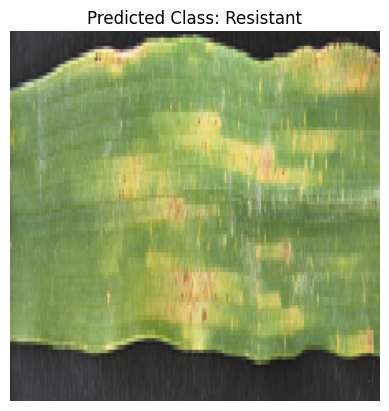

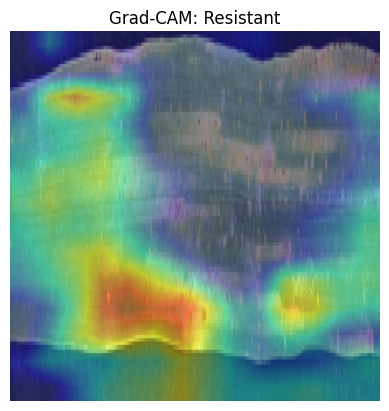

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf

# Load the trained VGG16 model
model = load_model('vgg16_model.h5')

# Load the image you want to predict
image_path = r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset\MS\4_MS_09.jpg"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img_array = np.array(img)
img_array = img_array / 255.0  # Rescale the image
img_array = img_array.reshape(1, 224, 224, 3)  # Add batch dimension

# Predict the label
predicted_label = model.predict(img_array)

# Define class names based on the labels
class_names = ['No disease', 'Resistant', 'Moderately Resistant', 
               'Moderately Resistant-Moderately Susceptible', 
               'Moderately Susceptible', 'Susceptible']

# Get the predicted class index
predicted_class_index = np.argmax(predicted_label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class (Normal output)
print("Predicted Class:", predicted_class)

# Display the image with the predicted label (Normal output)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

# **Explainable AI (Grad-CAM) Implementation:**
# Grad-CAM generates heatmaps to highlight regions that contributed most to the prediction

def generate_grad_cam_heatmap(model, img_array, class_index, layer_name="block5_conv3"):
    # **Step 1: Define the Grad-CAM model using the last convolutional layer and the output layer**
    last_conv_layer = model.get_layer(layer_name)
    
    # Define a model that maps the input image to the last convolutional layer's output and predictions
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    # **Step 2: Compute the gradient of the predicted class with respect to the convolutional output**
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # The loss corresponds to the class index
    
    # **Step 3: Compute the gradients of the class with respect to the convolutional outputs**
    grads = tape.gradient(loss, conv_outputs)
    
    # **Step 4: Pool the gradients across all axes to get a single weight per feature map**
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # **Step 5: Multiply the convolutional output by the pooled gradients to obtain the heatmap**
    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads.numpy(), axis=-1)
    
    # **Step 6: Normalize the heatmap to make it more interpretable**
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))  # Resize to image size
    heatmap = heatmap / np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap

# **Step 7: Generate Grad-CAM heatmap**
heatmap = generate_grad_cam_heatmap(model, img_array, predicted_class_index)

# **Step 8: Convert the heatmap to a color map and overlay it on the original image**
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# **Step 9: Superimpose the heatmap on the original image for visualization**
superimposed_img = np.uint8(255 * img_array[0])  # Rescale to 255 for visualization
superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap, 0.4, 0)

# **Step 10: Display the image with Grad-CAM heatmap (Explainable AI output)**
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM: {predicted_class}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 236ms/step
Predicted Class: Resistant


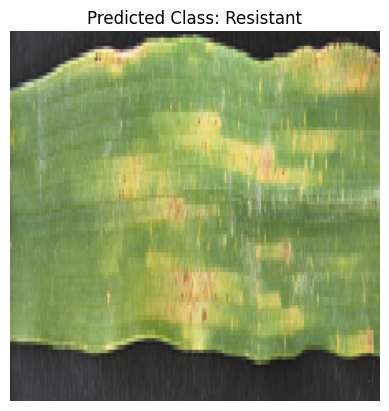

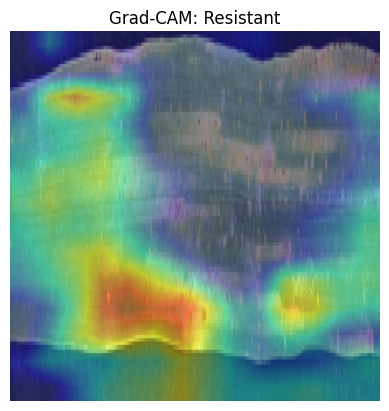

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf

# Load the trained VGG16 model
model = load_model('vgg16_model.h5')

# Load the image you want to predict
image_path = r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset\MS\4_MS_09.jpg"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img_array = np.array(img)
img_array = img_array / 255.0  # Rescale the image
img_array = img_array.reshape(1, 224, 224, 3)  # Add batch dimension

# Predict the label
predicted_label = model.predict(img_array)

# Define class names based on the labels
class_names = ['No disease', 'Resistant', 'Moderately Resistant', 
               'Moderately Resistant-Moderately Susceptible', 
               'Moderately Susceptible', 'Susceptible']

# Get the predicted class index
predicted_class_index = np.argmax(predicted_label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class (Normal output)
print("Predicted Class:", predicted_class)

# Display the image with the predicted label (Normal output)
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

# **Explainable AI (Grad-CAM) Implementation:**
# Grad-CAM generates heatmaps to highlight regions that contributed most to the prediction

def generate_grad_cam_heatmap(model, img_array, class_index, layer_name="block5_conv3"):
    # **Step 1: Define the Grad-CAM model using the last convolutional layer and the output layer**
    last_conv_layer = model.get_layer(layer_name)
    
    # Define a model that maps the input image to the last convolutional layer's output and predictions
    grad_model = tf.keras.models.Model([model.input], [last_conv_layer.output, model.output])

    # **Step 2: Compute the gradient of the predicted class with respect to the convolutional output**
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # The loss corresponds to the class index
    
    # **Step 3: Compute the gradients of the class with respect to the convolutional outputs**
    grads = tape.gradient(loss, conv_outputs)
    
    # **Step 4: Pool the gradients across all axes to get a single weight per feature map**
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # **Step 5: Multiply the convolutional output by the pooled gradients to obtain the heatmap**
    conv_outputs = conv_outputs[0]
    heatmap = np.mean(conv_outputs * pooled_grads.numpy(), axis=-1)
    
    # **Step 6: Normalize the heatmap to make it more interpretable**
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))  # Resize to image size
    heatmap = heatmap / np.max(heatmap)  # Normalize to [0, 1]
    
    return heatmap

# **Step 7: Generate Grad-CAM heatmap**
heatmap = generate_grad_cam_heatmap(model, img_array, predicted_class_index)

# **Step 8: Convert the heatmap to a color map and overlay it on the original image**
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# **Step 9: Superimpose the heatmap on the original image for visualization**
superimposed_img = np.uint8(255 * img_array[0])  # Rescale to 255 for visualization
superimposed_img = cv2.addWeighted(superimposed_img, 0.6, heatmap, 0.4, 0)

# **Step 10: Display the image with Grad-CAM heatmap (Explainable AI output)**
plt.imshow(superimposed_img)
plt.title(f"Grad-CAM: {predicted_class}")  # **This output is the Explainable AI visualization**
plt.axis('off')
plt.show()



1/1 [==============================] - 0s 308ms/step


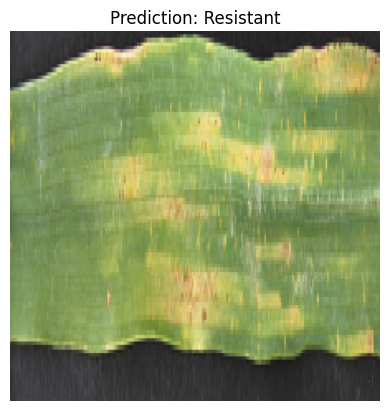


🔍 **Prediction:** Resistant

🛡 **Status:** Resistant to Disease  
                - Continue using resistant wheat varieties.  
                - Maintain optimal soil conditions.  
                - Keep monitoring to prevent any unexpected infections.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

class WheatDiseaseAnalyzer:
    def __init__(self, model_path='vgg16_model.h5'):
        self.model = load_model(model_path)
        self.class_names = [
            'No disease', 'Resistant', 'Moderately Resistant', 
            'Moderately Resistant-Moderately Susceptible', 
            'Moderately Susceptible', 'Susceptible'
        ]
        self.recommendations = {
            'No disease': """✅ **Status:** Healthy Crop  
                - No intervention is required.  
                - Maintain regular field monitoring.  
                - Ensure proper irrigation and nutrient supply.""",

            'Resistant': """🛡 **Status:** Resistant to Disease  
                - Continue using resistant wheat varieties.  
                - Maintain optimal soil conditions.  
                - Keep monitoring to prevent any unexpected infections.""",

            'Moderately Resistant': """⚠ **Status:** Minor Infection Detected  
                - Apply targeted fungicide treatments to affected areas.  
                - Rotate crops to minimize disease build-up.  
                - Maintain proper ventilation and spacing between plants.""",

            'Moderately Resistant-Moderately Susceptible': """🔴 **Status:** Moderate Risk of Infection  
                - Immediate fungicide application is required.  
                - Isolate and monitor infected sections of the crop.  
                - Improve soil health with organic matter and proper fertilization.""",

            'Moderately Susceptible': """🆘 **Status:** High Risk of Disease Spread  
                - Apply **strong fungicide** immediately.  
                - Consider **replacing affected crops** if necessary.  
                - Sanitize soil and maintain crop rotation strategies.""",

            'Susceptible': """🚨 **Status:** Critical Infection Detected  
                - Quarantine **severely affected crops** to prevent spread.  
                - Conduct **complete field sanitization**.  
                - Plan for future planting with **disease-resistant varieties**.  
                - Avoid replanting in the same infected soil without treatment."""
        }

    def predict_disease(self, image_path):
        """Predict disease and provide a detailed recommendation."""
        # Load & preprocess image
        img = image.load_img(image_path, target_size=(224, 224))
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(1, 224, 224, 3)

        # Predict disease
        predicted_label = self.model.predict(img_array)
        predicted_class_index = np.argmax(predicted_label)
        predicted_class = self.class_names[predicted_class_index]

        # Get recommendation
        recommendation = self.recommendations.get(predicted_class, "No recommendation available.")

        # Show output
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction: {predicted_class}")
        plt.show()

        print(f"\n🔍 **Prediction:** {predicted_class}\n")
        print(recommendation)

        return {"predicted_class": predicted_class, "recommendation": recommendation}

# Example usage
analyzer = WheatDiseaseAnalyzer()
result = analyzer.predict_disease(r"D:\Yellow-Rust-disease-prediction-in-wheat-main\Yellow-Rust-disease-prediction-in-wheat-main\Dataset\MS\4_MS_09.jpg")


In [56]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [57]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

6/6 [==============================] - 48s 8s/step
              precision    recall  f1-score   support

           0       0.72      0.56      0.63        77
           1       0.42      0.35      0.38        71
           2       0.27      0.73      0.40        22
           3       0.49      0.53      0.51        55
           4       0.63      0.56      0.59        66
           5       0.73      0.67      0.70        66

    accuracy                           0.54       357
   macro avg       0.54      0.57      0.53       357
weighted avg       0.58      0.54      0.55       357



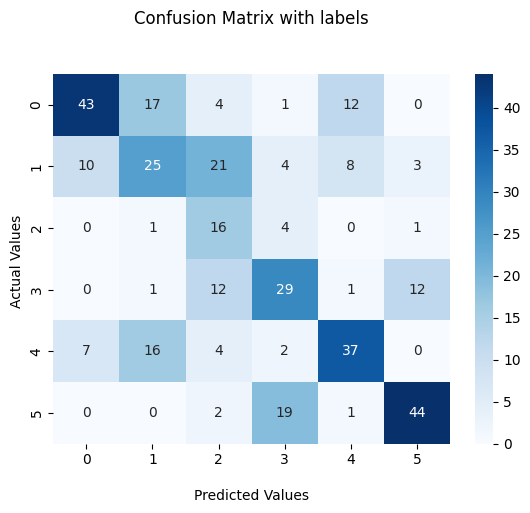

In [58]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [31]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.25      1.00      0.40         1

    accuracy                           0.70        10
   macro avg       0.62      0.83      0.60        10
weighted avg       0.93      0.70      0.76        10



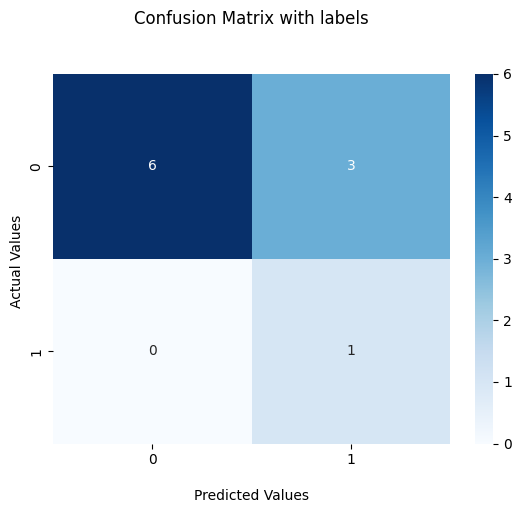

In [32]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()